# Tutorials

This [jupyter](http://jupyter.org/) notebook describes the tutorials (examples), supplied with `openInjMoldSim`.
The `demo` example should serve as a starting point for developing injection molding simulations, i.e. changing the mesh and process parameters.
It also presents an experimental validation of the predicted cavity pressure evolutions.
The `test` examples are intended to numerically validate some important aspects of the solver.

## Demo

An [experimental investigation (see paper)](http://rdcu.be/lfnt) of the injection molding process is modeled.
This simulation case was also described in a [conference paper (in Slovenian)](http://www.drustvozamehaniko.si/zbornik/ZbornikKD2017.pdf).
For a description of a similar experimental investigation with HDPE, see the [second paper](http://rdcu.be/uGWT).
The HDPE investigation is not modeled in this repository.

![filling](demo/demo_geom.png)

### Geometry

The filling position in the model was not P0 (the feed system) but the P1 position which is in the cavity.
This makes the domain simpler and excludes the modeling of the pressure drop at the gate, eliminating a possible source of uncertainty.

![Selection_017.png](tutorials_img/Selection_017.png)

The model uses a 2D description of the actual cavity and also assumes a uniform cavity thickness.
Note, that the above image is schematic and the actual cavity is much more elongated.
This allowed to create the mesh using the `blockMesh` utility with the simplest setup.

#### Changing the geometry

To use a different geometry, either modify the [`constant/polyMesh/blockMeshDict`](demo/fill_pack/constant/polyMesh/blockMeshDict) file or supply a "general" mesh.
One way to use a "general" mesh is to import an Ansys Fluent mesh.
An example of doing this is demonstrated in the [wedgePlease](https://github.com/krebeljk/wedgePlease) repository.
Not using the `blockMesh` utillity requires removing the call to `blockMesh` from the [`AllRun`](demo/fill_pack/AllRun) script.
An `./AllMesh` call could be made from the [`AllRun`](demo/fill_pack/AllRun) script, where an `AllMesh` script could include a call to `fluentMeshToFoam`.
Applying `openInjMoldSim` in practice might be feasible for an axi-symmetric model.

### Setup

#### Material parameters

`openInjMoldSim` models the polymer and the air but the air is very simplified.
For the material parameters of either see the respective `thermophysicalProperties` files in the [`constant`](demo/fill_pack/constant) directory.
Note, that the air viscosity is not realistic and neither is the air venting.
The viscosity of the air was artificially increased to avoid the possible occurrence of turbulence and related convergence issues.
The air viscosity was still set far lower than the viscosity of the polymer.
The polymer thermal conductivity is described by the [`kappaTable`](demo/fill_pack/constant/kappaTable) and the specific heat by the [`cpTable`](demo/fill_pack/constant/cpTable) (basic SI units are used with temperature in kelvin).
The `cpTable` could have been supplied as pressure dependent by including data points for pressures other than 0, but this would only make sense in modeling a semi-crystalline polymer with lumped latent heat released at higher crystallization temperatures in case of higher pressure.
The syntax for two (0 and 100 MPa -- probably not enough) pressure data points would have been:

```
(
(273.15((0 1377.715)(1e8 1477.715)))
(323.15((0 1482.72013)(1e8 1582.72013)))
(328.15((0 1493.23916)(1e8 1593.23916)))
...
(390.15((0 1967.39298)(1e8 2067.39298)))
(392.15((0 1971.60316)(1e8 2071.60316)))
(623.15((0 2456.715)(1e8 2556.715)))
)
```

#### Boundary conditions

Boundary conditinos are set together with the initial conditions in the [org0](demo/fill_pack/org0) directory.

The thermal boundary conditions account for the [heat transfer coefficient](https://en.wikipedia.org/wiki/Heat_transfer_coefficient) with the `externalWallHeatFluxTemperature` keyword.
See the [org0/T](demo/fill_pack/org0/T) file.
The keyword `h` sets the value of the heat transfer coefficient.
The keyword `Ta` is the mold temperature.
The keyword `kappa` is required for the boundary condition to obtain the material thermal conductivity (this way the temperature gradient can be used to calculate the heat flux).
Since the solver uses a non-constant thermal conductivity (dependent on temperature and pressure) it makes this value available to the boundary condition by writing the field `mojKappaOut`.
This field is not written to the results time folder because it is of little value for the post processing.

The inlet pressure at P1 is set to match the experiment by calling the external file [fim_01_01_F_00_00_01_08.txt](demo/fill_pack/fim_01_01_F_00_00_01_08.txt) from [org0/p_rgh](demo/fill_pack/org0/p_rgh).

```c++
    inlet
    {
       type uniformFixedValue;
       uniformValue table 
#      include "$FOAM_CASE/fim_01_01_F_00_00_01_08.txt"
    }
```

#### Procedure

The simulation procedure is set in the [`AllRun`](demo/fill_pack/AllRun) script.
Venting the air out of the cavity requires designating an outlet for the filling phase and closing it for the packing phase.

Initial files are first set.

```shell
# Initial files
cp -r org0 0
cp system/controlDict0 system/controlDict
cp system/fvSolution0 system/fvSolution
blockMesh
setFields
```

This copies the initial and boundary conditions from `org0` to the `0` directory (where they may be modified by the code).
The `AllRun` script runs the solver multiple times with different settings (e.g. each time extending the simulation time).
Therefore, `controlDict0` and `fvSolution0` are the initial non-modified versions.
`blockMesh` creates the mesh.
`setFields` puts a small amount of material at the gate to make the simulation start better conditioned -- prevent high injection velocities due to small inertia of the air-filled cavity.

The following runs the filliing phase with the outlet open and renames the log file corresponding to the filling phase.

```shell
# fill
phase='_fill'
runApplication $application
mv 'log.'$application 'log.'$application$phase
```

The following code seals the outlet and runs the first portion of the packing phase.

```shell
# pack1
phase='_pack1'
sed -i -e 's/^deltaT\s.*;/deltaT 1e-10;/g' 0.135/uniform/time # change init deltaT
changeDictionary -latestTime -dict system/changeDictionaryDict.bcpack
changeDictionary -instance system -dict system/changeDictionaryDict.ctrl1
runApplication $application
mv 'log.'$application 'log.'$application$phase
```


The change in the boundary conditions implies a very sudden change in the solution development which was resolved by reducing the time step with the `sed` replacement in the last results dictionary.
The keyword `deltaT` from the `system/controlDict` is ignored in an analysis starting from the `latestTime` and the initial time step in a restart analysis is read from the `0.135/uniform/time` file.
Using `sed` inside of `AllRun` is indeed cumbersome, since care must be taken to match the directory name.

### Results

The evolution of the fields can be viewed by calling `paraFoam` from within the case directory.

#### Filling progress

The `alpha.poly` field describes the phase distribution. If its value is 1, it means the space is occupied by the polymer. If it's 0, it's occupied by the air.

![Selection_019.png](tutorials_img/Selection_019.png)

#### Filling pressure

![Selection_020.png](tutorials_img/Selection_020.png)

#### Packing pressure

In [4]:
%%latex
\[t = 1.1\; \mathrm{s}\]

<IPython.core.display.Latex object>

![Selection_021.png](tutorials_img/Selection_021.png)

#### Packing temperature

In [5]:
%%latex
\[t = 1.1\; \mathrm{s}\]

<IPython.core.display.Latex object>

![Selection_022.png](tutorials_img/Selection_022.png)

#### Pressure evolution

A steeper than measured pressure decrease during packing is expected due to the assumption of the rigid mold walls [(see paper)](http://rdcu.be/lfnt).

![filling](demo/plot.png)

## Test

Some numerical validations are included.
* **Viscosity** -- `crossWLF`: The viscosity in the model must adhere to the Cross-WLF model.
* **Heat transfer** -- `heatTranser`: The heat transfer in the model mush be a proper solution of the heat diffussion equation.
* **Solid shear modulus value** -- `shearModulus`: The value of the shear modulus of the solid phase.
* **Equation of state** -- `taitEq`: The specific volume of the melt.

### Viscosity: `crossWLF`

A virtual rheometer was set up following the example from the [sourceflux.de blog post](http://www.sourceflux.de/blog/shear-rheometer-openfoam/).
The viscosity in the model is calculated as if it were measured in an experiment and this value is verified to match the Cross-WLF model value, calculated in the supplied python script. 
The geometry was modified to a cuboid cavity to make the shear rate field constant in the whole domain (i.e. homogenious).
An additional library `mojLibForces` (provided in the solver directory) needs to be compiled to enable the force calculation. 

![Selection_024.png](tutorials_img/Selection_024.png)

#### Analysis

In [55]:
%%latex
The force on the top face of the cuboid is the product of the constant shear stress $\tau$ and the surface area $A_0$:
\begin{equation}
F = A_0 \cdot \tau = A_0 \cdot \dot\gamma \eta =  A_0 \cdot U /\mathrm{Thc} \; \eta.
\end{equation}

<IPython.core.display.Latex object>

In [61]:
%%latex
\begin{align}
\dot\gamma \ldots \mathrm{shear\;rate}\\
\eta \ldots \mathrm{viscosity}\\
U \ldots \mathrm{velocity}\\
\mathrm{Thc} \ldots \mathrm{thickness}
\end{align}

<IPython.core.display.Latex object>

##### Calculation

The following is basically the [analyze.py](test/crossWLF/analyze.py) script.
It assumes the simulation has been performed.

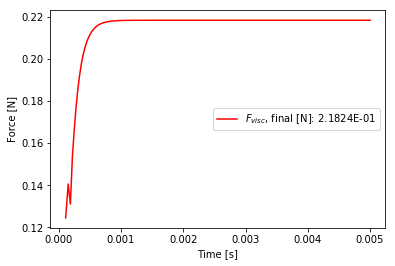

Viscosity in the model: 2182.36479 Pa s
Expected viscosity:     2182.44388755 Pa s


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import re
import os

class crossWLFcase: #namespace
    
    def crossWLF(T, shr, p):
        n    = 0.252 #1
        Tau  = 30800.0 #Pa
        D1   = 4.76e10 #Pa s
        D2   = 373.15 #K
        D3   = 0.51e-6 #K
        A1   = 25.7 #1
        A2   = 61.06 #K
        Tz   = D2
        eta0 = D1 * np.exp( -A1 * (T-Tz-D3*p) /(A2 + (T-Tz)) )
        eta  = eta0 / ( 1 + np.power( eta0 * shr / Tau , 1-n) )
        return eta

    Tc = 200 # degC
    p = 60e6 # Pa
    L = 0.01 # m
    W = 1e-4 # m
    Thc = 1e-3 # m
    U = 0.1 # m/s
    T = Tc + 273.15 # K
    A0 = L*W
    shr = U/Thc

    forcesFileName = os.path.realpath("./test/crossWLF/postProcessing/forces/0/forces.dat")

    forcesFileContent = open(forcesFileName).read()
    forcesFileContent = re.sub('[()]', '', forcesFileContent)

    open(forcesFileName, 'w').write(forcesFileContent)

    forces = np.loadtxt(forcesFileName, skiprows=3)

    time = forces[:, 0]
    force = forces[:, 5]

    fig, ax = plt.subplots(1)

    labels = ["$F_{visc}$, final [N]: %.4E" % force[-1] ]

    plt.xlabel("Time [s]")
    plt.ylabel("Force [N]")
    plt.plot(time, force, color='red')
    plt.legend(labels, loc="center right")
    #plt.savefig('forceInTime.png')
    plt.show()

    print('Viscosity in the model:', force[-1]/(A0 * shr), 'Pa s')
    viscP = crossWLF(T, shr, p)
    print('Expected viscosity:    ', viscP, 'Pa s')


##### Shear rate field

The shear rate field is practically homogeneous and approximately 0.01 1/s.

![Selection_025.png](tutorials_img/Selection_025.png)

##### Domain

The solution does not change along *y*.
The domain could be made smaller by making the length *L* shorter.

### Heat transfer: `heatTransfer`

A test of the energy equation solution is performed.
The case was modified to match a 1D [heat transfer](https://en.wikipedia.org/wiki/Heat_equation) case of a solid which was simulated using the finite element method.
A more elegant way of doing this would be to calculate the temperature field evolution in a python script.
The temperature evolutions in the wall center are compared.
This example does not consider the possibiliy where density nonhomogeneity would introduce a discrepancy.

#### Temperature field

Below is the temperature field at $t = 4$ s in Celsius. 
The material is being heated through the left- and right-hand side faces where contact to a hot mold is assumed.

![Selection_026.png](.Tutorials_img/Selection_026.png)

#### Temperature evolution

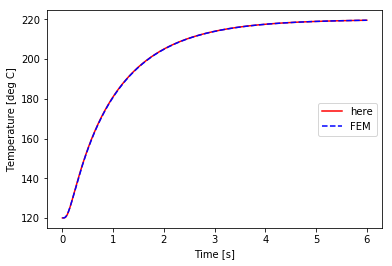

In [10]:
import numpy as np
from matplotlib import pyplot as plt
import os

class heatTransferCase: #namespace
    
    #load OF data
    fileNameOF = os.path.realpath("./test/heatTransfer/postProcessing/probes/0/Tc")
    Tc = np.loadtxt(fileNameOF, skiprows=3)
    
    #load FEM data
    fileNameFEM = os.path.realpath("./test/heatTransfer/referenceTEvol.dat")
    TcFEM = np.loadtxt(fileNameFEM)

    fig, ax = plt.subplots(1)

    labels = ["here", "FEM"]

    plt.xlabel("Time [s]")
    plt.ylabel("Temperature [deg C]")
    plt.plot(Tc[:,0], Tc[:,1], color='red')
    plt.plot(TcFEM[:,0], TcFEM[:,1], '--', color='blue')
    plt.legend(labels, loc="center right")
    #plt.savefig('heatTransfer.png')
    plt.show()

### Solid shear modulus vaule: `shearModulus`

Stress in the solid develops with the deformation of the solid.
This test validates that the `shearModulus` setting in the [solidificationProperties](test/shearModulus/constant/solidificationProperties0) dictionary implies the value of the calculated stress in the solid.

#### Procedure

The simulation is composed of two `openInjMoldSim` calls.
The `solidificationProperties` are modified inbetween so the initial file is being kept under a different name.
The `controlDict` likewise.

```shell
# Initial files
cp -r org0 0
cp system/controlDict0 system/controlDict
cp constant/solidificationProperties0 constant/solidificationProperties
blockMesh
```

During the first run no solid stress is present because the [solidificationProperties](test/shearModulus/constant/solidificationProperties0) prohibit it with value of the `shrRateLimEl` keyword.
This could also be achieved by a very high value for `viscLimEl`. The `solidificationProperties` dictinary in the first run reads:

```c
shearModulus 600e6;//Pa

shrRateLimEl -1.0;//1/s  //elasticity appears at lower shear rates than this

viscLimEl -1.0;//1/s  //elasticity appears at higher viscosities than this
```

The first run establishes a simple shearing field -- like in the `crossWLF` case.

The [`Allrun`](test/shearModulus/Allrun) script then changes the `shrRateLimEl` keyword.

```shell
changeDictionary -instance constant -dict system/changeDictionaryDict.cons
```

The [system/changeDictionaryDict.cons](test/shearModulus/system/changeDictionaryDict.cons) dictionary cotains the following (to allow the elastic stress to develop):
```c
dictionaryReplacement
{
    solidificationProperties
    {
        shrRateLimEl 1e10;//1/s
    }
}
```

#### Analysis

The second run with the development of the elastic stress simulates $\Delta t = 10^{-6}$ s of material shearing at the shearing rate of $\dot\gamma = 100$ 1/s.
The affected strain tensor component at the end is expected to be

$\tau = G \; \dot\gamma \; \Delta t = 600 \cdot 10^{6} \cdot 100 \cdot 10^{-6} = 60$ kPa



This matches the calculated value inspected with `paraView`. 

![Selection_027.png](tutorials_img/Selection_027.png)

#### Limitation

This test, unfortunately, does not validate whether the this stress correctly acts on the material.
Such a validation is not available with the same procedure as used in the case of `crossWLF` viscosity because of the way the wall force is calculated in the `crossWLF` case (view the `mojForcesLib` library in the solver directory).
On the other hand, it can be verified that the solid stress does stop the material flow in the packing phase which is a strong indication that it correctly acts on the material (solid stress can be eliminated in the demo case by deleting or renaming the [`constant/solidificatinoProperties`](demo/fill_pack/constant/solidificationProperties) dictionary).

#### The use of the `solidificationProperties` dictionary

Elastic shear modulus is effected when the viscosity surpasses the viscosity threshold `viscLimEl` specified in the `solidificationProperties`
dictionary. To control this according to temperature, change the `TnoFlow` temperature of the CrossWLF model in the `constant/thermophysicalProperties.poly` dictionary.
Mind the `etaMax` value to be greater than `viscLimEl` to have it surpass the threshold.
According to
experience, elastic behavior should be limited to slow flow. This is effected with the `shearRate` limit.

### Equation of state: `taitEq`

The specific volume in the model is verified to follow the Tait equation.
The material is fully contained and heated.
Temperature and pressure both increase but density can only change due to redistribution of mass since the total mass and volume remain constant.

The following is the density field at $t = 1$ s.

![Selection_028.png](tutorials_img/Selection_028.png)

#### Analysis

Temperature, pressure and density are probed in the cavity center.
Assuming the temperature and pressure in the model, the density is calculated with python and compared to the density probed at the center of the cavity by the simulation.

The following is effectively the [analyze.py](test/taitEq/analyze.py) script.

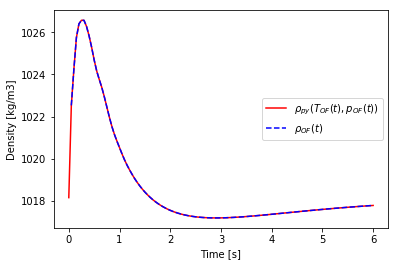

In [19]:
import numpy as np
from matplotlib import pyplot as plt

class taitEqCase: # namespace

    def tait(T, p):
        b1m    =    9.76e-4
        b2m    =    5.8e-7
        b3m    =    1.67e8
        b4m    =    3.6e-3
        b1s    =    9.76e-4
        b2s    =    2.3e-7
        b3s    =    2.6e8
        b4s    =    3.0e-3
        b5     =    373.0
        b6     =    5.1e-7
        b7     =    0.0
        b8     =    0.0
        b9     =    0.0
        Cuniv  =    0.0894
        if T > b5 + b6*p:
            v0 = b1m + b2m * (T-b5)
            B = b3m * np.exp(-b4m * (T-b5))
            v1 = 0.0
        else:
            v0 = b1s + b2s * (T-b5)
            B = b3s * np.exp(-b4s * (T-b5))
            v1 = b7 * np.exp(b8 * (T-b5) - b9*p)
        specV = v0 * ( 1.0 - Cuniv* np.log(1.0 + p/B)) + v1
        return specV

        
    pressFileName = os.path.realpath("./test/taitEq/postProcessing/probes/0/p")
    tmprFileName = os.path.realpath("./test/taitEq/postProcessing/probes/0/Tc")
    rhoFileName = os.path.realpath("./test/taitEq/postProcessing/probes/0.05/rho")

    press = np.loadtxt(pressFileName, skiprows=3)
    tmpr = np.loadtxt(tmprFileName, skiprows=3)
    rho = np.loadtxt(rhoFileName, skiprows=3)
    n_vals = len(tmpr[:,0])
    dens = np.zeros((n_vals,2))

    for i in range(n_vals):
        dens[i,1] = 1/tait(tmpr[i,1]+273.15, press[i,1])
        dens[i,0] = tmpr[i,0]

    fig, ax = plt.subplots(1)

    labels = ["$\\rho_{py}(T_{OF}(t),p_{OF}(t))$", "$\\rho_{OF}(t)$"]
    axes = plt.gca()
    plt.xlabel("Time [s]")
    plt.ylabel("Density [kg/m3]")
    plt.plot(dens[:,0], dens[:,1], color='red')
    plt.plot(rho[:,0], rho[:,1], color='blue', linestyle='dashed')
    plt.legend(labels, loc="center right")
    #plt.savefig('densityInTime.png')
    plt.show()